### Get the HMFs for all sims:

In [2]:
import numpy as np
from gal_goku import hmf as halo_mass_func

for fid in ['L2']:
    base_dir = f'/scratch/06536/qezlou/Goku/FOF/{fid}/narrow/'
    save_File = f'/scratch/06536/qezlou/Goku/processed_data/HMF/{fid}_hmfs_narrow.hdf5'
    hmf = halo_mass_func.Hmf()
    hmf.get_all_fof_hmfs(base_dir=base_dir, save_file=save_File)
    print(f'fid = {fid} is done!')

[ 000000.00 ]   0: 01-10 17:15  Hmf             INFO     Logger initialized at level: 20
[ 000000.00 ]   0: 01-10 17:15  Hmf             INFO     MPI_COMM_WORLD | size = 1 -- Nbkit COMM | size = 1


## Plot HMFs:

Spline smoothing: use mass bins of 0.1 dex and interpolate with cubic spline to get hmf on 0.05 dex mass bins.

This only marginally helps to suppress the fluctuations in L2 HMF (compare "interpolated" and "fine bin" where the latter is the HMF directly on 0.05 dex, hence a bit noisier)

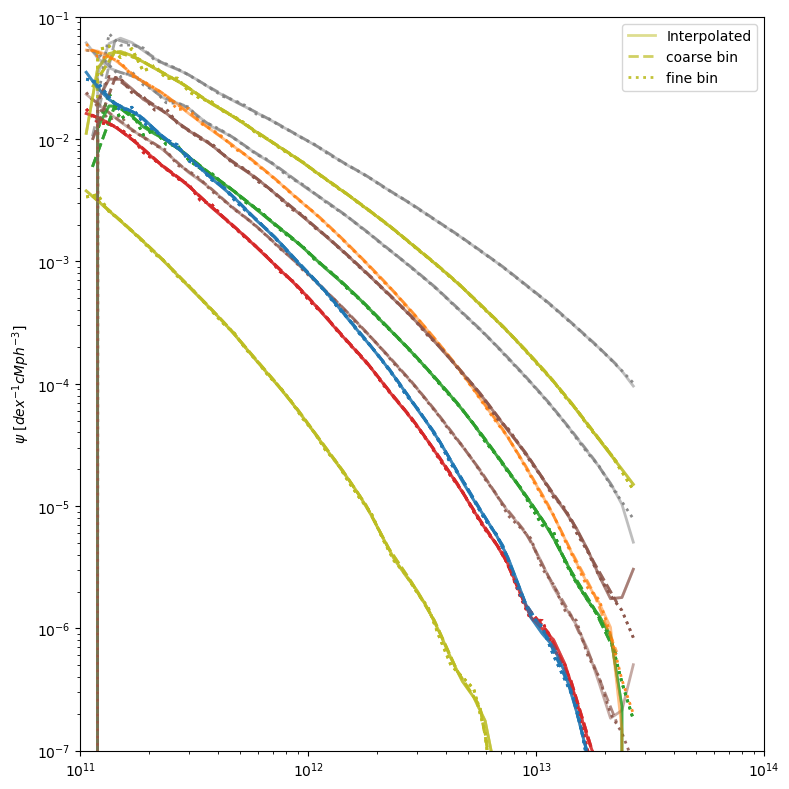

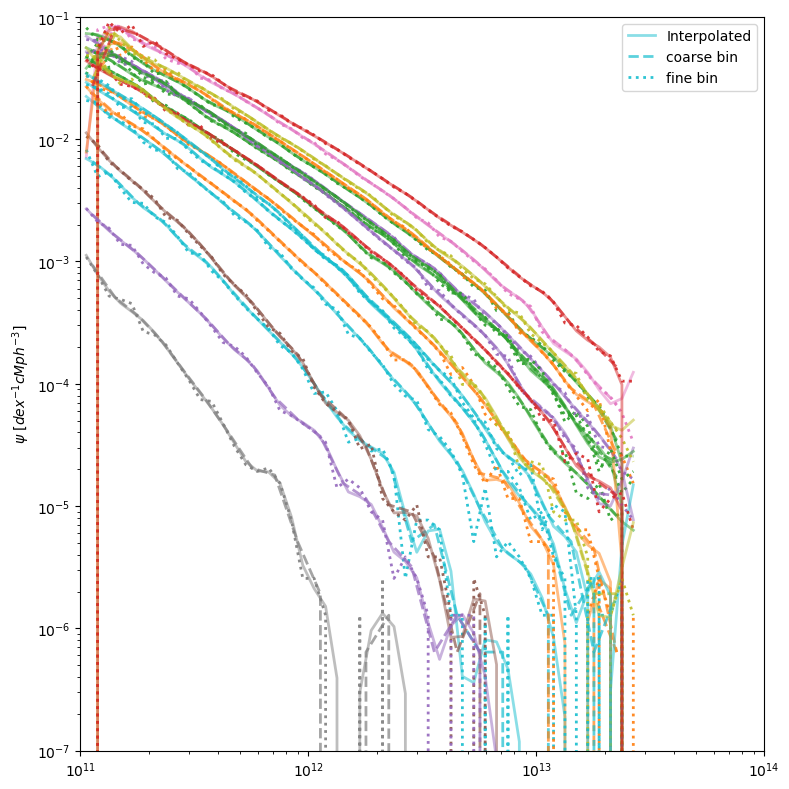

In [3]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.check_smoothed_hmf(fids=['HF','L2'])

## Comapre fidelities:

2025-01-09 17:12:52.995468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 17:12:53.088435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-09 17:12:53.088457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-09 17:12:53.115236: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 17:12:53.560381: W tensorflow/stream_executor/platform/de

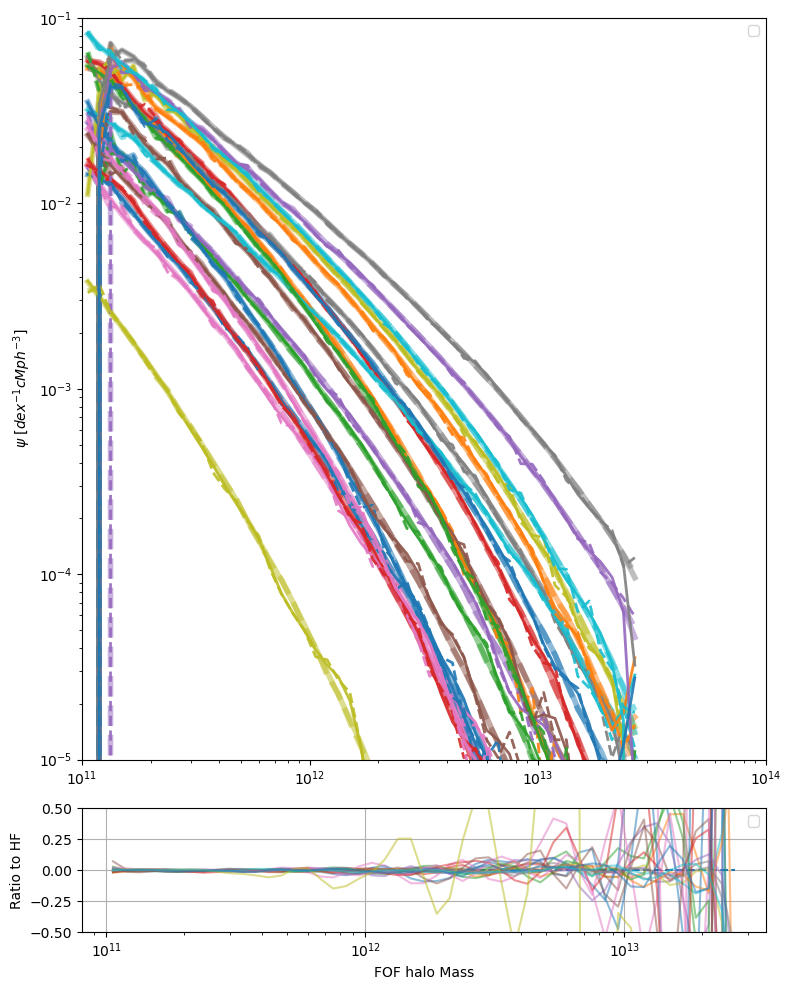

In [1]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.compare_fids(fids=['HF', 'L2'])

## Quadratic Spline: k=2

In [5]:
from scipy.interpolate import make_lsq_spline
from gal_goku import summary_stats
import numpy as np
import matplotlib.pyplot as plt

def do_spline(k=2, seed=None, narrow=False):
    if seed is not None:
        np.random.seed(seed)
    data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
    halo_mass_func = summary_stats.HMF(data_dir=data_dir, fid='L2', narrow=narrow)
    hmf, mbins, _, hmfs_coarse, mbin_coarse, _ = halo_mass_func.load_hmf_sims(load_coarse=True)


    fig, ax = plt.subplots(figsize=(8, 6))
    x = np.linspace(mbins[0], mbins[-1], 1000)
    for i, ind in enumerate(np.random.choice(range(hmf.shape[0]), 10)):
        t = mbins[np.arange(0, len(mbins), 4)]  # Create knots at every 4th mass bin
        t = np.r_[[mbins[0]] * k, t, [mbins[-1]] * k]  # Add degree repetitions at boundaries
        spl = make_lsq_spline(mbin_coarse, hmfs_coarse[ind], k=k, t=t)

        ax.plot(mbin_coarse, hmfs_coarse[ind], color=f'C{i}', label='Original HMF')
        ax.plot(x, spl(x), color=f'C{i}', ls='--', label=f'Smoothedwwith k = {k}')
        if i == 0:
            ax.legend()
        ax.set_xscale('log')
        ax.set_yscale('log')
        if narrow:
            ax.set_ylim(1e-5, 1e-1)

/tmp/ipykernel_35538/349355574.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs from L2_hmfs_narrow.hdf5
01/20/2025 11:03:47 AM Loading narrow HMFs fr

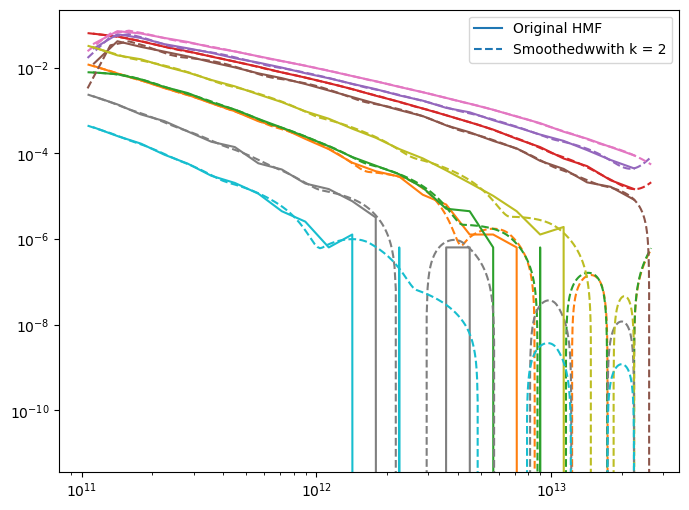

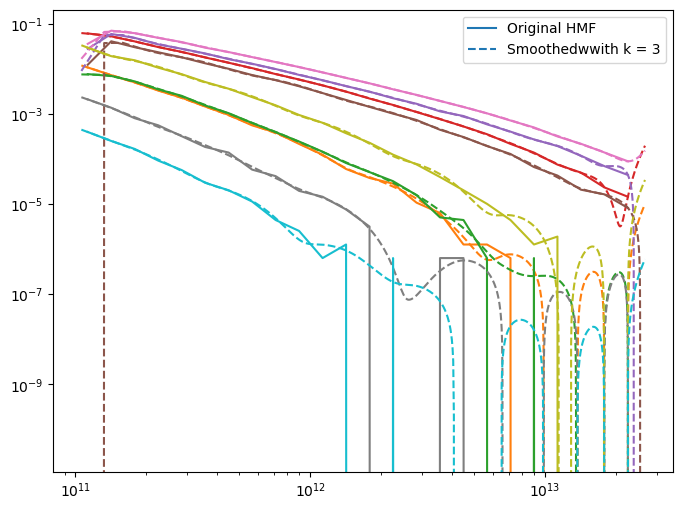

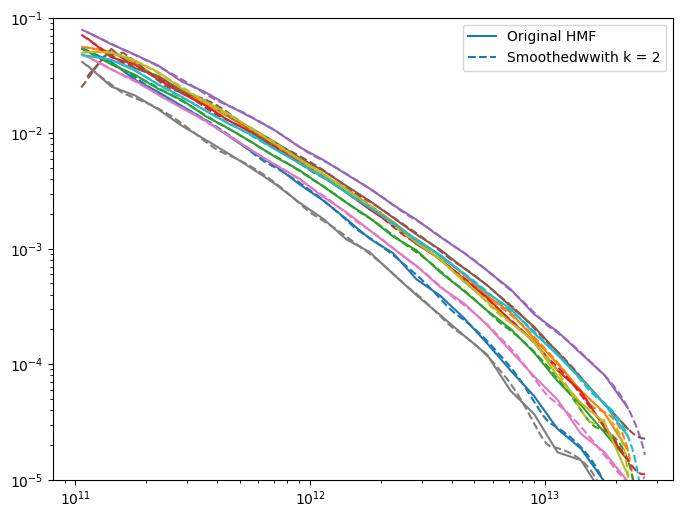

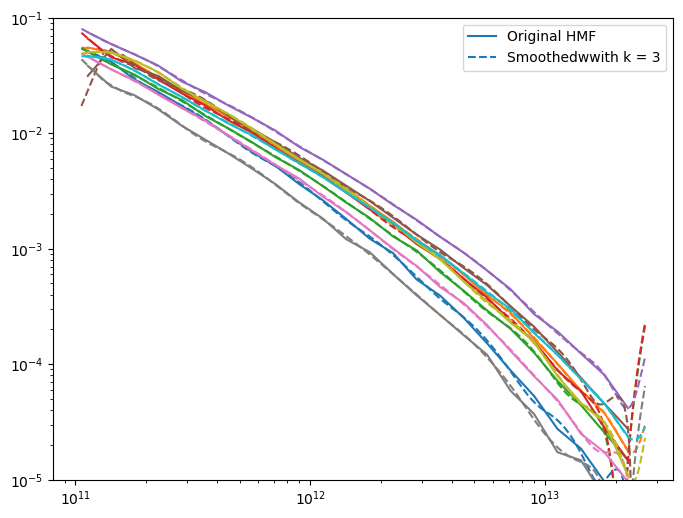

In [6]:
do_spline(k=2, seed=10)
do_spline(k=3, seed=10)
do_spline(k=2, seed=12, narrow=True)
do_spline(k=3, seed=12, narrow=True)

`xtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 355, CG iterations: 155, optimality: 2.98e-08, constraint violation: 0.00e+00, execution time: 0.081 s.


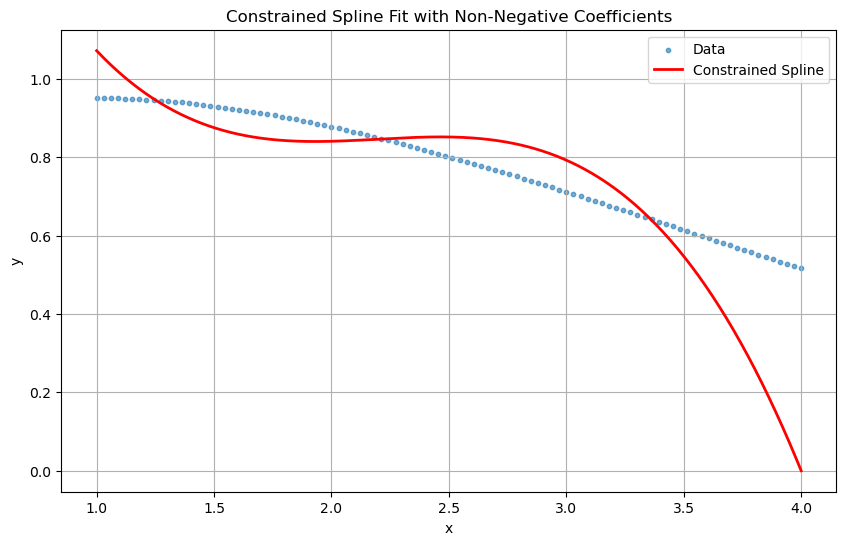

In [117]:
import numpy as np
from scipy.interpolate import BSpline, splev, splrep
from scipy.optimize import minimize
from scipy.linalg import lstsq

class ConstrainedSplineFitter:
    def __init__(self, degree=3):
        """
        Initialize the fitter for constrained splines.
        Parameters:
        degree (int): Degree of the spline (default is 3 for cubic splines).
        """
        self.degree = degree

    # Improved initial guess and optimization method
    def fit_spline(self, x, y, knots):
        t = np.r_[[x[0]] * self.degree, knots, [x[-1]] * self.degree]  # Knot vector
        def basis_matrix(x, t, k):
            return np.column_stack([BSpline.basis_element(t[i:i + k + 2])(x) for i in range(len(t) - k - 1)])

        
        B = basis_matrix(x, t, self.degree)

        # Initial coefficients guess: least squares fit
        c0, _, _, _ = lstsq(B, y)
        c0 = np.maximum(c0, 0)  # Ensure non-negative initial guess


        # Objective function: minimize squared residuals
        def objective(c):
            return np.sum((B @ c - y) ** 2)

# Constraint: The highest-order term coefficient (last basis function) must be non-negative
        constraints = [{'type': 'ineq', 'fun': lambda c: -c[-1]}]

        # Use a more robust optimization method
        result = minimize(
            objective,
            c0,
            constraints=constraints,
            method='trust-constr',
            options={'disp': True,
            'maxiter': 10000}
        )

        if not result.success:
            raise RuntimeError("Optimization failed: " + result.message)

        return BSpline(t, result.x, self.degree)


    def evaluate_spline(self, spline, x_eval):
        """
        Evaluate the constrained spline at new points.
        
        Parameters:
        spline (BSpline): Fitted spline object.
        x_eval (array): Points to evaluate the spline.
        
        Returns:
        array: Evaluated values.
        """
        return splev(x_eval, spline)

# Example usage
if __name__ == "__main__":
    np.random.seed(42)
    x = np.linspace(1, 4, 100)
    #y = 0.5 * x**2 - 2 * x + 1 + np.random.normal(0, 1, size=len(x))
    y = x**0.1 * np.exp(-0.05*x**2)

    fitter = ConstrainedSplineFitter(degree=3)
    knots = np.linspace(1, 4, 2)  # Internal knot positions
    spline = fitter.fit_spline(x, y, knots)

    x_eval = np.linspace(1, 4, 500)
    y_eval = splev(x_eval, spline)

    # Visualization
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=10, label="Data", alpha=0.6)
    plt.plot(x_eval, y_eval, label="Constrained Spline", color="red", linewidth=2)
    plt.legend()
    plt.title("Constrained Spline Fit with Non-Negative Coefficients")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()
